<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

From this I learned that sometimes balanced trees are better because they're more intuitive and more common for computers.

**Task2**:

What is a decision tree? How do they work?

A decision tree is like a flowchart that starts at one root node. They can have multiple children and the children can have children. At each node, some condition is evaluated and that allows the tree to decide where to move next. More layers of the tree provides a more "accurate" fit but can also lead to overfitting. Each layer sorts the things that are being predicted into certain areas of the predictor.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of the tree is how many layers it has, or how many generations of children the root has. Depending on the amount of data, you can determine the proper depth. For the dataset in the notes, more than 2 layers is too much. More layers capture more patterns but too many layers can lead to overfitting. This is a key con of decision trees because they're prone to overfitting and have a harder time to generalize.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are a group of several trees. At each iteration, it randomly alters the trees. After several interations, you end up with lots of different trees with different layers/branches. The alterations are based on the other trees and this allows growth (boosting). Changes to the trees are selected as part of an MCMC so that the whole BART is a sample from a posterior distribution of possible random forests. BART also has a mechanism of regularizing priors that ensures that the trees don't get too deep or too far from the actual data.

**Task5**:

Why would we use a BART model instead of a decision tree?

BART takes the positive features of RF and minimizes its flaws like underfitting/overfitting. So it's better because it's flexible and accurate.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree

In [4]:
!pip install pymc-bart
!pip install preliz

In [5]:
import pymc_bart as pmb
import preliz as pz

In [7]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [8]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [11]:
X = penguins[['flipper_length', 'bill_depth', 'bill_length']].to_numpy()
Y = penguins['body_mass'].to_numpy()

In [12]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

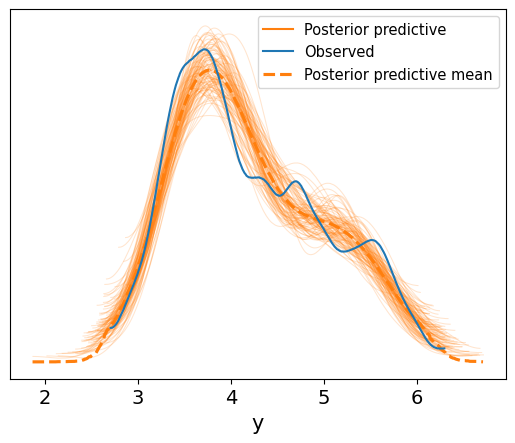

In [14]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_penguin, model_penguin, extend_inferencedata=True)
az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [18]:
posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


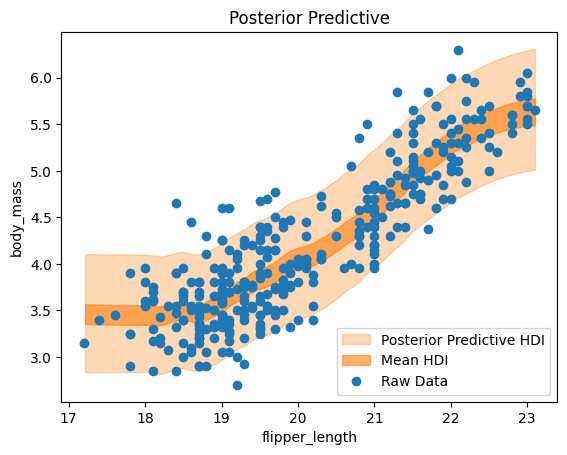

In [19]:
idx = np.argsort(X[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think that this graph does capture most of the true association between flipper length and body mass. The model follows the flatness near the low and high flipper lengths and the mostly linear increase in the middle. The only issue is that some of the high body mass points are not captured in the posterior predictive HDI region. Overall, I think this captures the true association well and that the model does fit the data.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

<Axes: ylabel='R²'>

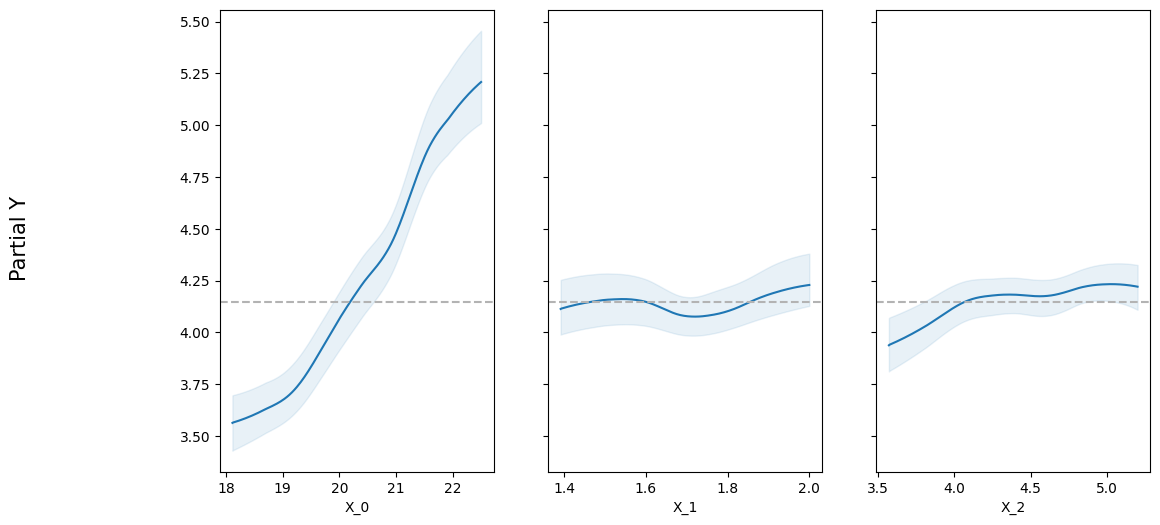

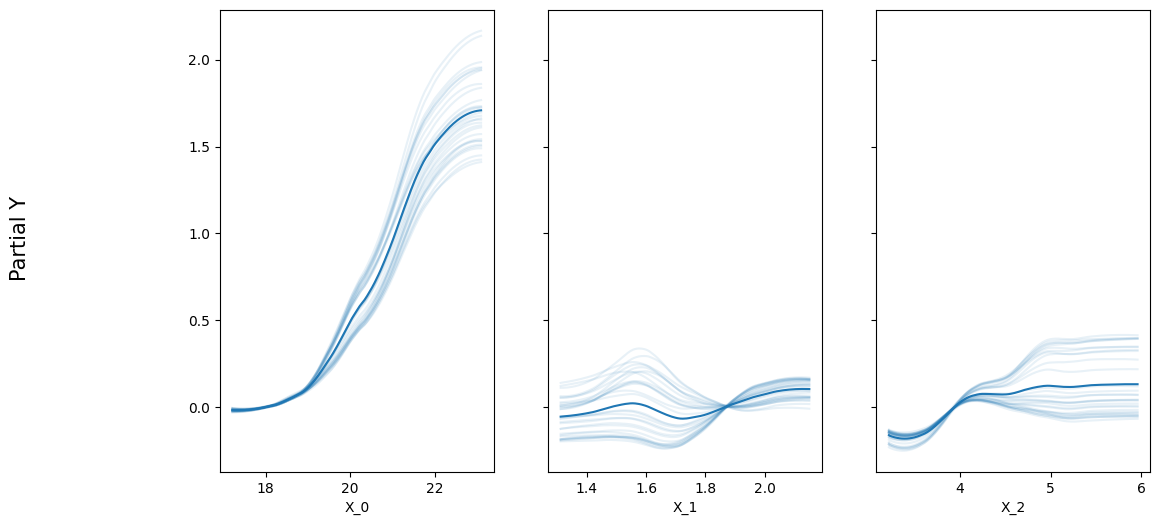

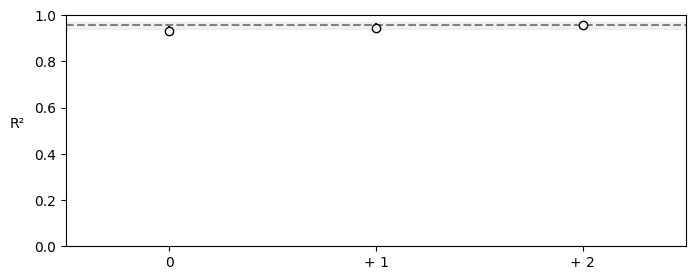

In [25]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))
#X_0 is flipper_length, X_1 is bill_depth, X_2 is bill_length

pmb.plot_ice( μ_, X, Y, grid=(1, 3), func=np.exp, figsize = (12,6))
#X_0 is flipper_length, X_1 is bill_depth, X_2 is bill_length

vi_penguins = pmb.compute_variable_importance(idata_penguin, μ_, X)
pmb.plot_variable_importance(vi_penguins)
#0 is flipper_length, +1 is bill_depth, +2 is bill_length

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Lets start with the relationship between flipper length and body mass. Starting with just the pdp, we can see that they appear to have a strong positive linear relationship. If we look into the ice plot, we can see more niche trends that don't show up in the pdp average. For flipper length and body mass, the ice plot shows us that near lower flipper lengths, theres a flattness that is very very stable and predictable, while near higher flipper lengths, there's still a positive linear trend but it gets more and more varied. The R^2 variable importance plot shows us that this predictor (along with the other two) is valuable and accurate.

Now, if we look at bill depth we can gather information from the pdp, ice and vi plots too. The pdp tells us that is a weaker positive trend with a slight dip in the middle. This is interesting but a little unqiue/unexpected so maybe the ice plots will give us more insight. The ice plots show a very different and intriguing picture. There is a lot of variation before bill depths of about 1.9. Some lines show an increasing then decreasing trend while some show a decreasing than increasing trend. After this crossing point of 1.9, there is still variation but a little less. They all mostly flatten out at the higher bill depths. The R^2 value in the vi plot shows us that this variable also contributes to high performance.

Finally, bill length's pdp shows a positive trend that slowly seems to flatten out. In the ice plots, we see that the lines are much tighter and stable at lower bill lengths but at higher bill lengths there is variations in predicted body mass values (but they all eventually flatten). This one also a useful variable due to the high R^2.

Overall, all three variables seem important, especially flipper length because of it's strong and relatively stable association. The variability of the ice plots in all three variables, especially bill depth, tell us that there are some interactions that we need to hone in on still.